# Lab03: Linear Discrimination
## Mehmet Gönen
### March 11, 2022

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats

def safelog(x):
    return(np.log(x + 1e-100))

## Parameters

In [2]:
np.random.seed(421)
# mean parameters
class_means = np.array([[+1.5, +1.5],
                        [-1.5, -1.5]])
# covariance parameters
class_covariances = np.array([[[+1.6, +1.2], 
                               [+1.2, +1.6]],
                              [[+1.6, -1.2], 
                               [-1.2, +1.6]]])
# sample sizes
class_sizes = np.array([120, 180])

## Data Generation

In [3]:
# generate random samples
points1 = np.random.multivariate_normal(mean = class_means[0,:],
                                        cov = class_covariances[0,:,:],
                                        size = class_sizes[0])
points2 = np.random.multivariate_normal(mean = class_means[1,:],
                                        cov = class_covariances[1,:,:],
                                        size = class_sizes[1])
X = np.vstack((points1, points2))

# generate corresponding labels
y = np.concatenate((np.repeat(1, class_sizes[0]), np.repeat(0, class_sizes[1])))

## Exporting Data

In [4]:
# write data to a file
np.savetxt("lab03_data_set.csv", np.hstack((X, y[:, None])), fmt = "%f,%f,%d")

## Plotting Data

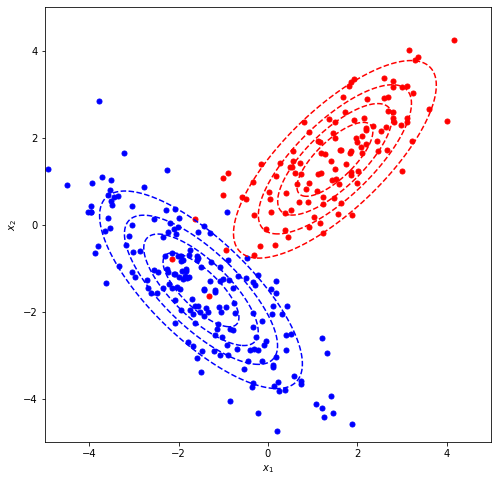

In [5]:
x1_interval = np.linspace(-5, +5, 1001)
x2_interval = np.linspace(-5, +5, 1001)
x1_grid, x2_grid = np.meshgrid(x1_interval, x2_interval)
X_grid = np.vstack((x1_grid.flatten(), x2_grid.flatten())).T

D1 = stats.multivariate_normal.pdf(X_grid, mean = class_means[0,:],
                                   cov = class_covariances[0,:,:])
D1 = D1.reshape((len(x1_interval), len(x2_interval)))
D2 = stats.multivariate_normal.pdf(X_grid, mean = class_means[1,:],
                                   cov = class_covariances[1,:,:])
D2 = D2.reshape((len(x1_interval), len(x2_interval)))

# plot data points generated
plt.figure(figsize = (8, 8))
plt.plot(points1[:,0], points1[:,1], "r.", markersize = 10)
plt.plot(points2[:,0], points2[:,1], "b.", markersize = 10)
plt.contour(x1_grid, x2_grid, D1, levels = [0.03, 0.06, 0.09, 0.12],
            colors = "r", linestyles = "dashed")
plt.contour(x1_grid, x2_grid, D2, levels = [0.03, 0.06, 0.09, 0.12],
            colors = "b", linestyles = "dashed")
plt.xlim((-5, +5))
plt.ylim((-5, +5))
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()

## Importing Data

In [6]:
# read data into memory
data_set = np.genfromtxt("lab03_data_set.csv", delimiter = ",")

# get X and y values
X = data_set[:,[0, 1]]
y_truth = data_set[:,2].astype(int)

# get number of samples
N = data_set.shape[0]

## Sigmoid Function

$\textrm{sigmoid}(\boldsymbol{w}^{\top} \boldsymbol{x} + w_{0}) = \dfrac{1}{1 + \exp\left[-(\boldsymbol{w}^{\top} \boldsymbol{x} + w_{0})\right]}$

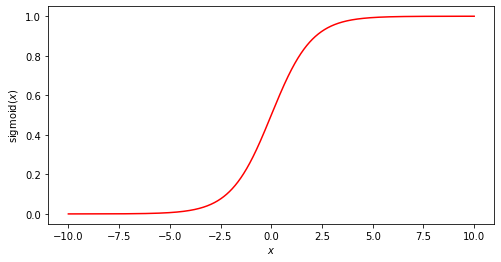

In [7]:
# define the sigmoid function
def sigmoid(X, w, w0):
    return(1 / (1 + np.exp(-(np.matmul(X, w) + w0))))

draw_seq = np.linspace(-10, +10, 2001)
plt.figure(figsize = (8, 4))
plt.plot(draw_seq, 1 / (1 + np.exp(-draw_seq)), "r-")
plt.xlabel("$x$")
plt.ylabel("sigmoid($x$)")
plt.show()

## Gradient Functions

\begin{align*}
\dfrac{\partial \textrm{Error}}{\partial \boldsymbol{w}} &= -\sum\limits_{i = 1}^{N} (y_{i} - \hat{y}_{i})\boldsymbol{x}_{i} \\
\dfrac{\partial \textrm{Error}}{\partial w_{0}} &= -\sum\limits_{i = 1}^{N} (y_{i} - \hat{y}_{i}) 
\end{align*}

In [8]:
# define the gradient functions
def gradient_w(X, y_truth, y_predicted):
    return(-np.matmul(y_truth - y_predicted, X))

def gradient_w0(y_truth, y_predicted):
    return(-np.sum(y_truth - y_predicted))

## Algorithm Parameters

In [9]:
# set learning parameters
eta = 0.01
epsilon = 0.001

## Parameter Initialization

In [10]:
# randomly initalize w and w0
np.random.seed(421)
w = np.random.uniform(low = -0.01, high = 0.01, size = X.shape[1])
w0 = np.random.uniform(low = -0.01, high = 0.01, size = 1)

## Iterative Algorithm

$\textrm{Error} = -\sum\limits_{i = 1}^{N} \left[ y_{i}\log(\hat{y}_{i}) + (1 - y_{i}) \log(1 - \hat{y}_{i}) \right]$

In [11]:
# learn w and w0 using gradient descent
iteration = 1
objective_values = []
while True:
    y_predicted = sigmoid(X, w, w0)

    objective_values = np.append(objective_values,
                                 -np.sum(y_truth * safelog(y_predicted) + 
                                         (1 - y_truth) * safelog(1 - y_predicted)))

    w_old = w
    w0_old = w0

    w = w - eta * gradient_w(X, y_truth, y_predicted)
    w0 = w0 - eta * gradient_w0(y_truth, y_predicted)

    if np.sqrt((w0 - w0_old)**2 + np.sum((w - w_old)**2)) < epsilon:
        break

    iteration = iteration + 1
print(w, w0)

[2.46001537 2.47111621] [2.08280287]


## Convergence

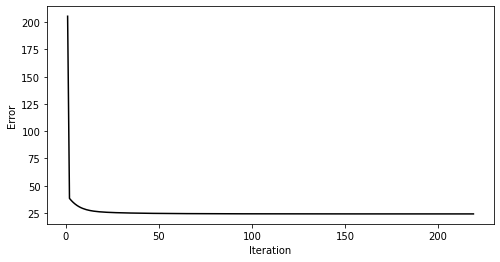

In [12]:
# plot objective function during iterations
plt.figure(figsize = (8, 4))
plt.plot(range(1, iteration + 1), objective_values, "k-")
plt.xlabel("Iteration")
plt.ylabel("Error")
plt.show()

## Training Performance

In [13]:
# calculate confusion matrix
y_predicted = 1 * (y_predicted > 0.5)
confusion_matrix = pd.crosstab(y_predicted, y_truth, 
                               rownames = ["y_pred"], 
                               colnames = ["y_truth"])
print(confusion_matrix)

y_truth    0    1
y_pred           
0        179    5
1          1  115


## Visualization

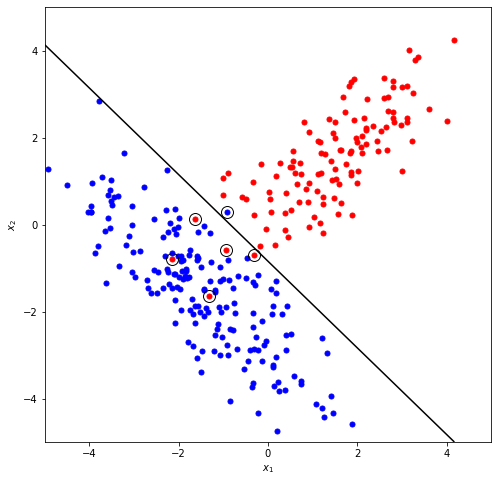

In [14]:
# evaluate discriminant function on a grid
x1_interval = np.linspace(-5, +5, 1001)
x2_interval = np.linspace(-5, +5, 1001)
x1_grid, x2_grid = np.meshgrid(x1_interval, x2_interval)
discriminant_values = w[0] * x1_grid + w[1] * x2_grid + w0

plt.figure(figsize = (8, 8))
plt.plot(X[y_truth == 1, 0], X[y_truth == 1, 1], "r.", markersize = 10)
plt.plot(X[y_truth == 0, 0], X[y_truth == 0, 1], "b.", markersize = 10)
plt.plot(X[y_predicted != y_truth, 0], X[y_predicted != y_truth, 1],
         "ko", markersize = 12, fillstyle = "none")
plt.contour(x1_grid, x2_grid, discriminant_values, levels = 0, colors = "k")
plt.xlim((-5, +5))
plt.ylim((-5, +5))
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()